In [1]:
from pathlib import Path
import json
import re
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from naming_conventions import *

In [2]:
# sns.set(style='whitegrid', font_scale=1.5)
# paper
sns.set_context("paper", rc={"font.size":11,"axes.titlesize":11,"axes.labelsize":11})

# relative path to data directory
data_dir = '../model_outputs_and_evals/'

In [3]:
inserts = set(['ADD_BEFORE', 'ADD_AFTER'])

def collect_counts(file):
    op_counter = Counter()
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            line = json.loads(line)
            ops = [d['operation'] if d['operation'] not in inserts else 'INSERT' for d in line]
            op_counter.update(ops)    
    return op_counter

def get_initial_params(file):
    model = Path(file).parent.name
    hps = Path(file).name.split("_")
    if model in ["ground_truth", "muss"]: # special cases
        # resources/outputs/ground_truth/asset.test.eval
        # resources/outputs/muss_en_mined/asset-test_default.eval
        test, example, prompt, ex_selector, few_n, refs, seed = hps[0], None, 'p2', None, None, None, '489'
        test = test.replace(".editops", "").replace('.', '-') # strip away extension and replace dots with dashes
        if 'muss_en_wikilarge_mined' in file.name:
            model = 'muss-wiki-mined'
            test = test.replace('_default_muss_en_wikilarge_mined', '')
        elif 'muss_en_mined' in file.name:
            model = 'muss-mined'
            test = test.replace('_default_muss_en_mined', '')
        elif model == 'ground_truth':
            model = 'ground truth'
    elif len(hps) == 6:
        test, example, prompt, few_n, refs, seed = hps
        ex_selector = "random"
    elif len(hps) == 7:
        test, example, prompt, ex_selector, few_n, refs, seed = Path(file).name.split("_")
    else:
        raise ValueError(f"Illegal number of parameters found in the file name: ({len(hps)}) {hps}")

    few_n = few_n.replace("fs", "") if few_n else None
    refs = refs.replace("nr", "") if refs else None
    seed = re.search(r'\d+', seed).group() if seed else None

    return [model, test, example, few_n, prompt, refs, seed, ex_selector]

data = {}

for i, file in enumerate(Path(data_dir).glob(f'*/*.editops')):
    model, test_set, _, _, prompt_id, _, random_seed, _ = get_initial_params(file)
    file_id = f'{model}_{test_set}_{prompt_id}_{random_seed}'
    data.setdefault(file_id, Counter())
    data[file_id].update(collect_counts(file))

df = pd.DataFrame.from_dict(data, orient='index')
df['model'], df['test_set'], df['prompt_id'], df['random_seed'] = zip(*df.index.str.split('_'))
df = df.reset_index(drop=True)
df

,KEEP,INSERT,DELETE,REPLACE,model,test_set,prompt_id,random_seed
0,5931,2498,861,1481,bloom-1b1,asset-test,p0,287
1,5966,2960,860,1447,bloom-1b1,asset-test,p0,489
2,5998,3141,935,1340,bloom-1b1,asset-test,p0,723
3,5385,490,1201,1687,bloom-1b1,asset-test,p1,287
4,5406,422,1321,1546,bloom-1b1,asset-test,p1,489
...,...,...,...,...,...,...,...,...
1195,5434,431,892,1947,muss-wiki-mined,asset-test,p2,489
1196,5217,367,1216,1674,muss-mined,med-easi-test,p2,489
1197,5607,323,941,1559,muss-wiki-mined,med-easi-test,p2,489
1198,4593,278,817,1498,muss-mined,news-manual-all-test,p2,489


In [4]:
# filter out cohere since not available for all test sets
print(len(df))
df = df[(~df['model'].str.startswith('cohere'))]
print(len(df))

1200
1197


In [5]:
df['model'].unique()

array(['bloom-1b1', 'bloom-3b', 'bloom-560m', 'bloom-7b1', 'bloom',
       'bloomz-1b1', 'bloomz-3b', 'bloomz-560m', 'bloomz-7b1', 'bloomz',
       'flan-t5-base', 'flan-t5-large', 'flan-t5-small', 'flan-t5-xl',
       'flan-t5-xxl', 'flan-ul2', 'gpt-j-6b', 'gpt-neox-20b',
       'ground truth', 'llama-13b', 'llama-30b', 'llama-65b', 'llama-7b',
       'openai-gpt-3.5-turbo', 'openai-text-ada-001',
       'openai-text-babbage-001', 'openai-text-curie-001',
       'openai-text-davinci-002', 'openai-text-davinci-003', 'opt-1.3b',
       'opt-13b', 'opt-30b', 'opt-6.7b', 'opt-66b', 'opt-iml-max-1.3b',
       'opt-iml-max-30b', 't0-3b', 't0', 't0pp', 't5-base-lm-adapt',
       't5-large-lm-adapt', 't5-small-lm-adapt', 't5-xl-lm-adapt',
       't5-xxl-lm-adapt', 'ul2', 'muss-mined', 'muss-wiki-mined'],
      dtype=object)

In [6]:
df['model'] = df['model'].replace(model_name_map)
df['model'].unique()
df['test_set'] = df['test_set'].replace(test_name_map)

/tmp/ipykernel_3397842/2156535638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'] = df['model'].replace(model_name_map)
/tmp/ipykernel_3397842/2156535638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_set'] = df['test_set'].replace(test_name_map)


In [7]:
# sort df according to model_name_map
df_mapping = pd.DataFrame({'model_sorted': list(model_name_map.values())})
sort_mapping = df_mapping.reset_index().set_index('model_sorted')
df['model_sorted'] = df['model'].map(sort_mapping['index'])
df.sort_values(by=['model_sorted', 'test_set', 'prompt_id', 'random_seed'], inplace=True)
df

/tmp/ipykernel_3397842/1780290124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_sorted'] = df['model'].map(sort_mapping['index'])
/tmp/ipykernel_3397842/1780290124.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['model_sorted', 'test_set', 'prompt_id', 'random_seed'], inplace=True)


,KEEP,INSERT,DELETE,REPLACE,model,test_set,prompt_id,random_seed,model_sorted
490,5092,398,1765,1416,Gold References,ASSET,p2,489,0
491,3472,1996,1735,2900,Gold References,Med-EASI,p2,489,0
489,4495,583,1021,1392,Gold References,Newsela,p2,489,0
1194,5583,396,960,1730,MUSS-mined,ASSET,p2,489,1
1196,5217,367,1216,1674,MUSS-mined,Med-EASI,p2,489,1
...,...,...,...,...,...,...,...,...,...
430,5023,114,1401,484,Flan-UL2,Newsela,p1,489,46
431,4960,166,1422,526,Flan-UL2,Newsela,p1,723,46
432,4908,236,1119,881,Flan-UL2,Newsela,p2,287,46
433,4808,276,1128,972,Flan-UL2,Newsela,p2,489,46


Found 57 results ASSET
Found 57 results Med-EASI
Found 57 results Newsela
Found 135 results ASSET
Found 135 results Med-EASI
Found 135 results Newsela
Found 57 results ASSET
Found 57 results Med-EASI
Found 57 results Newsela
Found 135 results ASSET
Found 135 results Med-EASI
Found 135 results Newsela
Found 57 results ASSET
Found 57 results Med-EASI
Found 57 results Newsela
Found 135 results ASSET
Found 135 results Med-EASI
Found 135 results Newsela


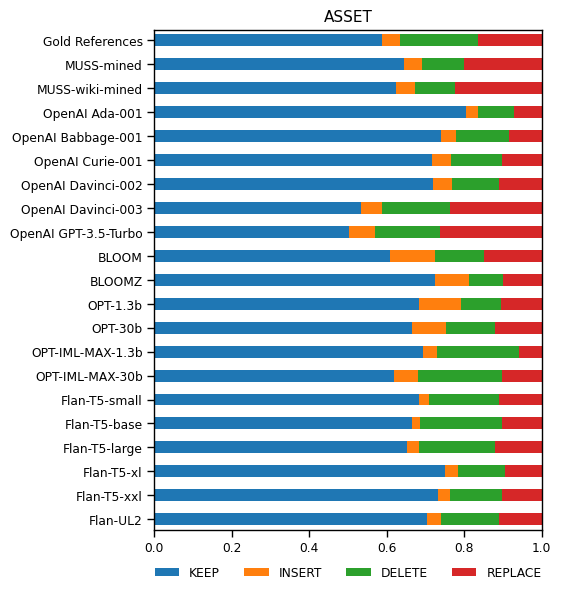

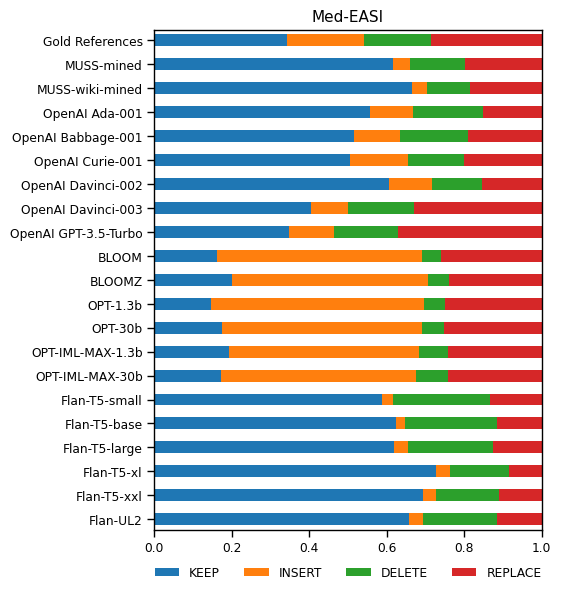

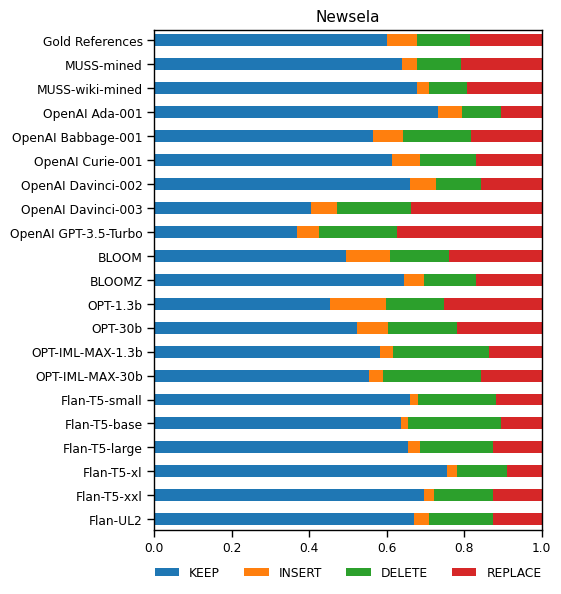

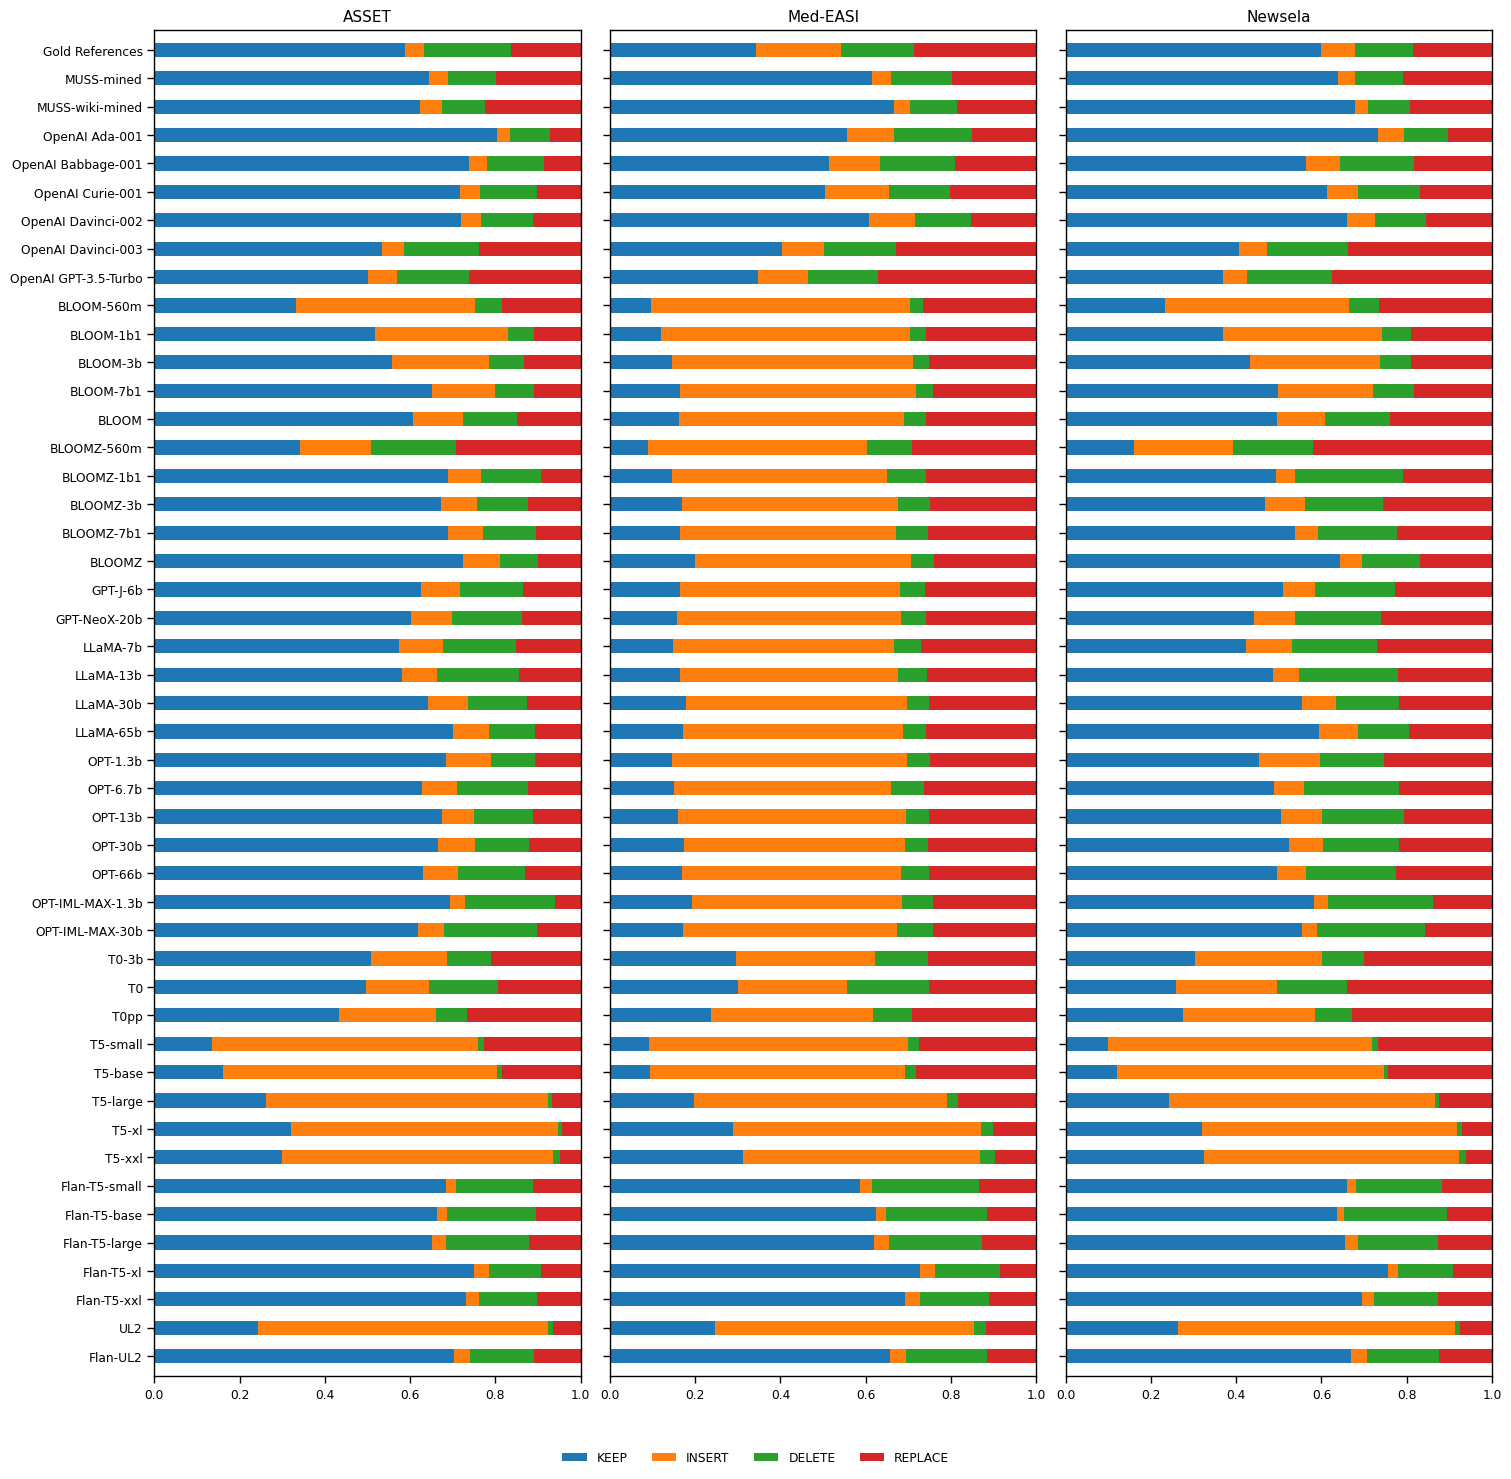

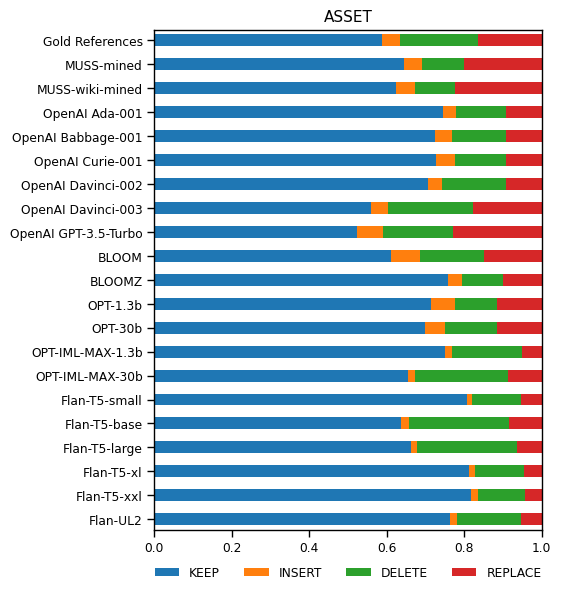

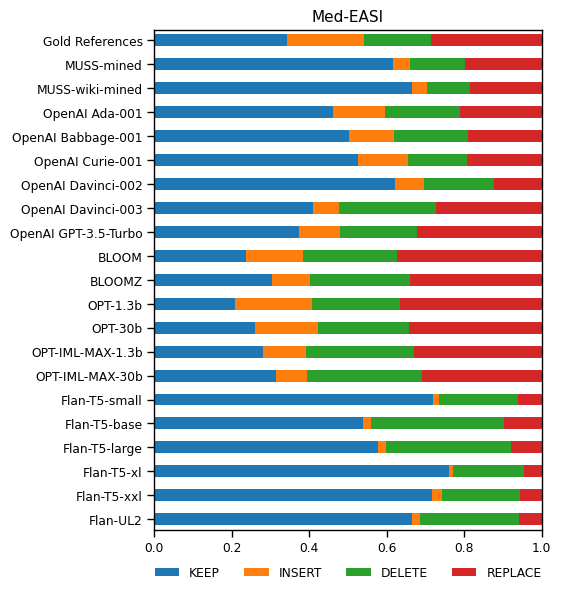

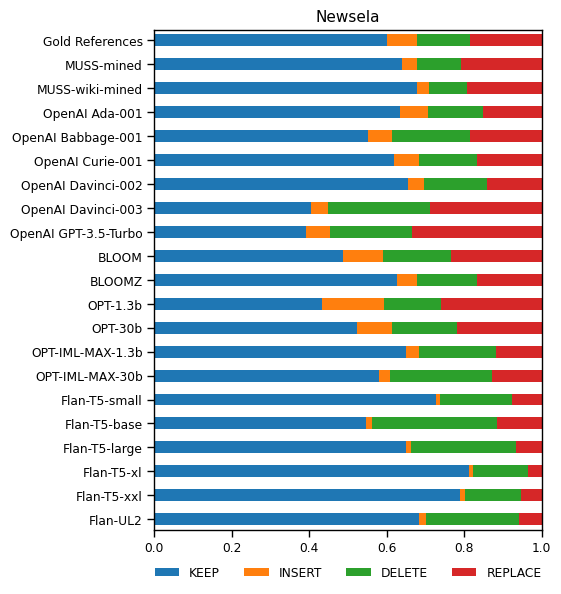

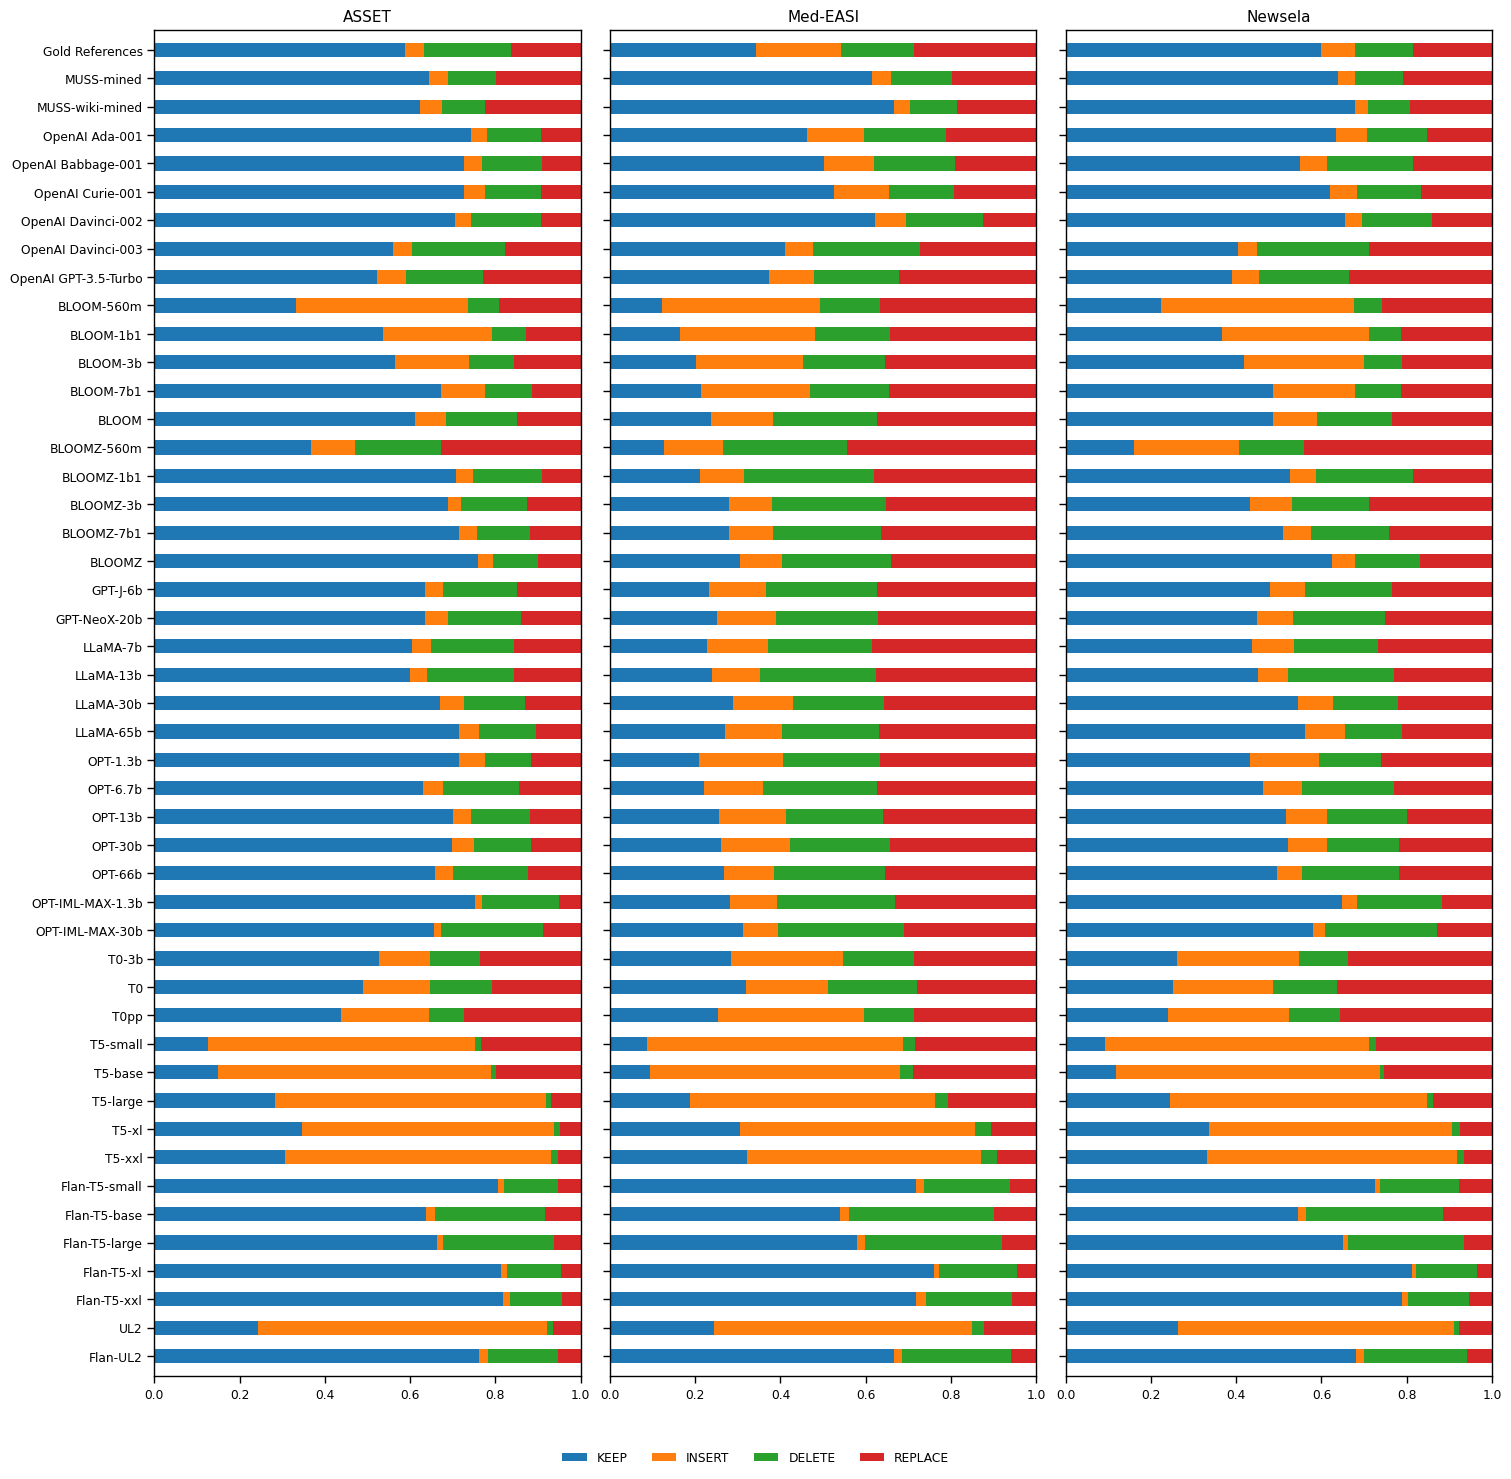

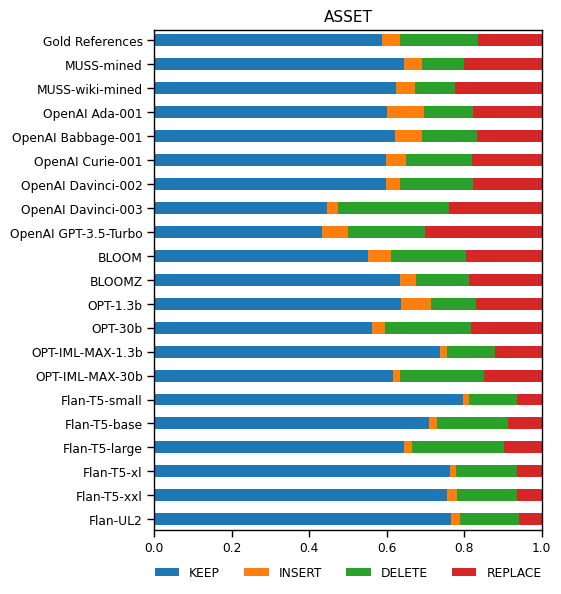

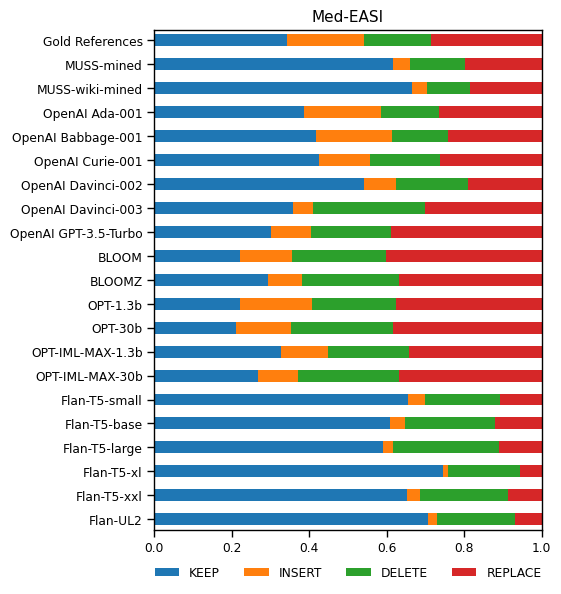

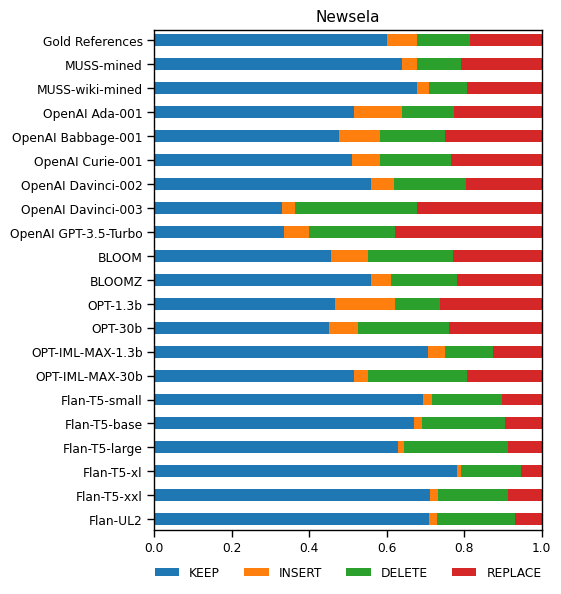

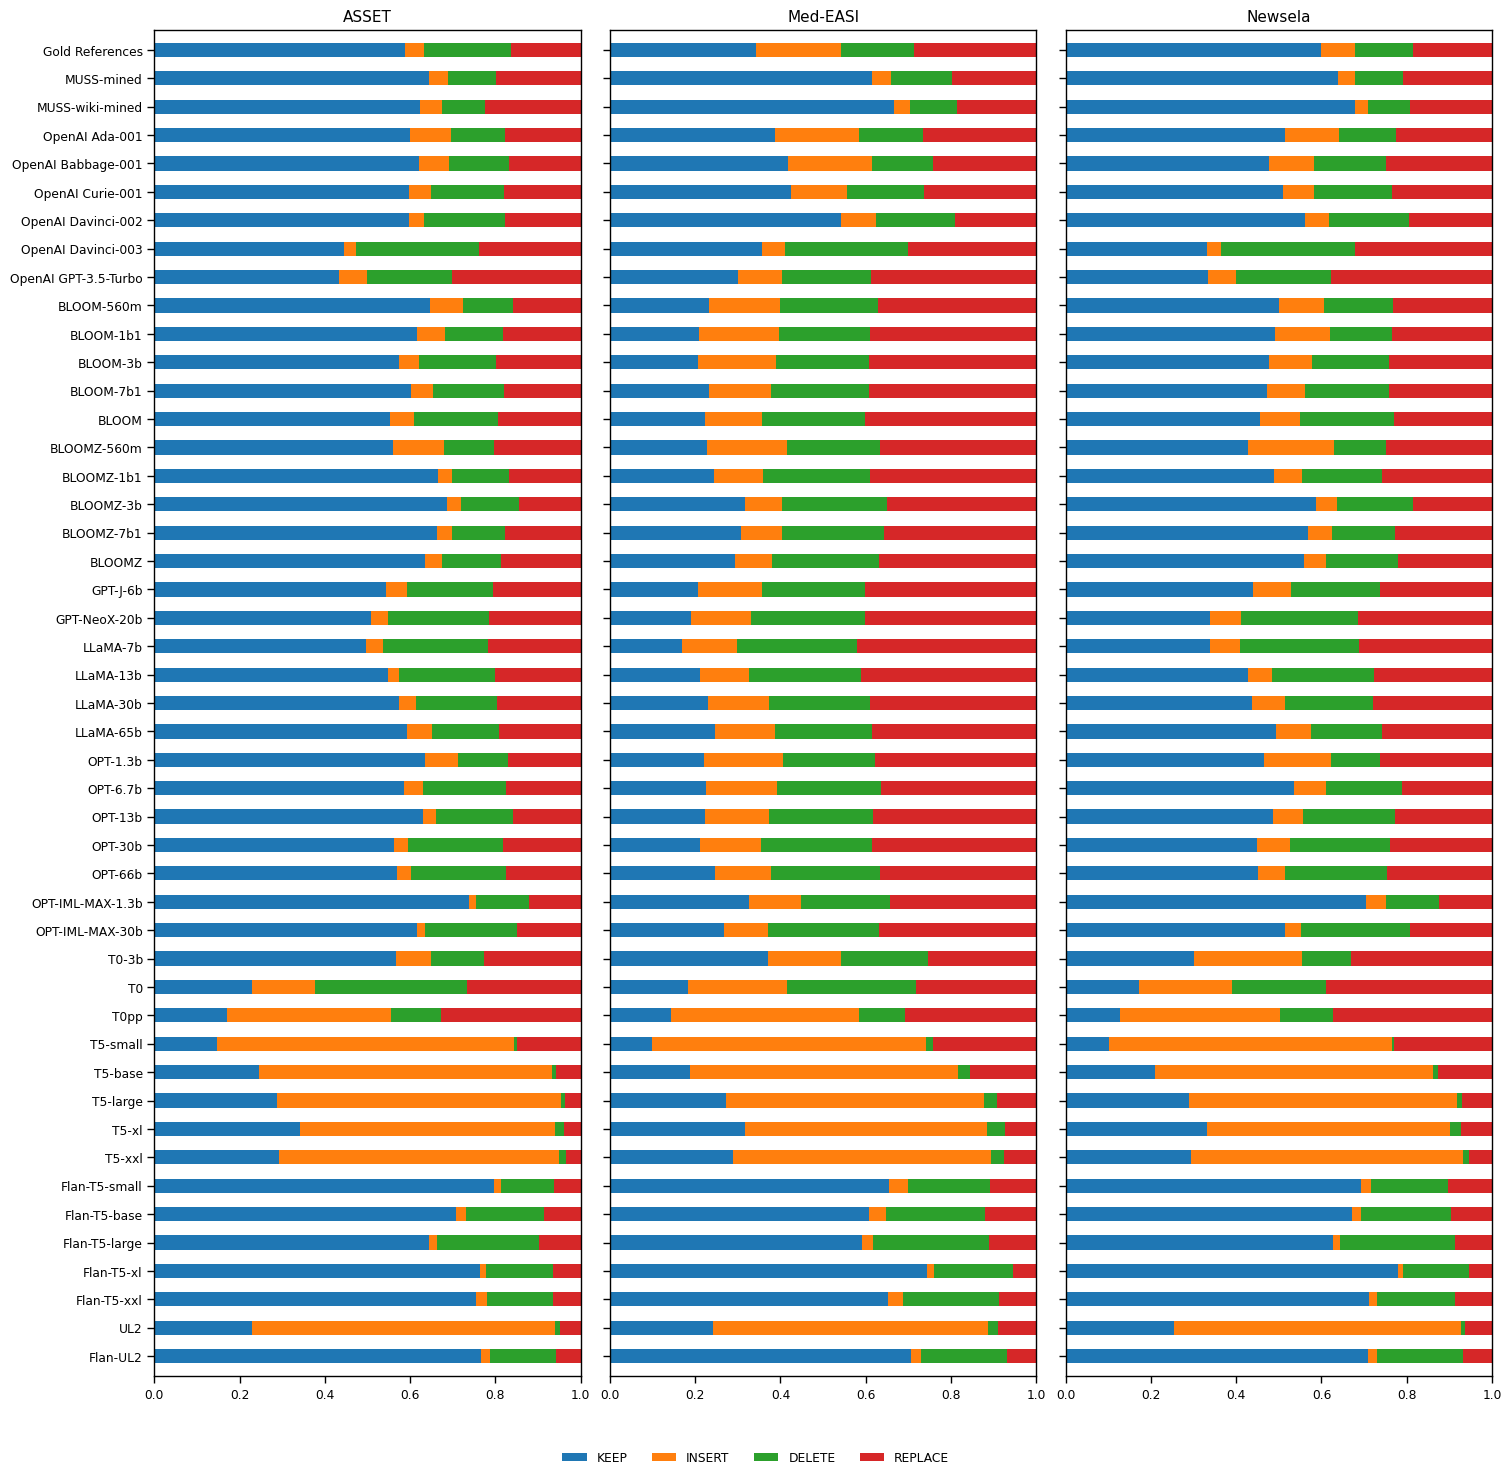

In [11]:
def plot_operation_counts(df, test_set, prompt_id='p2', aggregate_by='model', bar_height=0.3, ax=None, axis_i=0, annotate=True, output_file=None):
    # Filter the DataFrame based on the test set
    filtered_df = df[df['test_set'] == test_set]
    filtered_df = filtered_df[(filtered_df['prompt_id'] == prompt_id) | (filtered_df['model'].isin(['Gold References', 'ground truth', 'MUSS-wiki-mined', 'muss-wiki-mined', 'MUSS-mined', 'muss-en-mined']))]

    if len(filtered_df) == 0:
        print(f"No results found for {test_set}")
        return
    else:
        print(f"Found {len(filtered_df)} results {test_set}")
    
    # Aggregate the operation counts
    if aggregate_by == 'prompt_id':
        filtered_df = filtered_df.groupby(['model', 'prompt_id']).mean(numeric_only=True).reset_index()
    elif aggregate_by == 'random_seed':
        filtered_df = filtered_df.groupby(['model', 'random_seed']).mean(numeric_only=True).reset_index()
    elif aggregate_by == 'both':
        filtered_df = filtered_df.groupby(['model', 'prompt_id', 'random_seed']).mean(numeric_only=True).reset_index()
    else:
        filtered_df = filtered_df.groupby('model').mean(numeric_only=True).reset_index()

    # Normalize the operation counts
    operations = ['KEEP', 'INSERT', 'DELETE', 'REPLACE']
    filtered_df[operations] = filtered_df[operations].div(filtered_df[operations].sum(axis=1), axis=0)

    # Sort the DataFrame by predefined 'model_sorted'
    filtered_df = filtered_df.sort_values(by='model_sorted', ascending=False).reset_index(drop=True)

    # Create a figure
    if not ax:
        fig, ax = plt.subplots(figsize=(5, (0.5 * len(filtered_df))-4))

    # Plot each model
    for index, row in filtered_df.iterrows():
        prev_val = 0
        for operation in operations:
            # print(row['model'], operation, row[operation], index, prev_val)
            ax.barh(y=index, width=row[operation], height=bar_height, left=prev_val, 
                    color=plt.cm.tab10(operations.index(operation)), #plt.cm.tab20(operations.index(operation) / len(operations)), 
                    label=operation if index == 0 else "")
            prev_val += row[operation]

    # Set the y-ticks to be the model names
    if axis_i == 0:
        ax.set_yticks(np.arange(len(filtered_df)))
        if aggregate_by == 'prompt_id':
            y_labels = filtered_df['model'] + ' - ' + filtered_df['prompt_id']
        elif aggregate_by == 'random_seed':
            y_labels = filtered_df['model'] + ' - ' + filtered_df['random_seed']
        elif aggregate_by == 'both':
            y_labels = filtered_df['model'] + ' - ' + filtered_df['prompt_id'] + ' - ' + filtered_df['random_seed']
        else:
            y_labels = filtered_df['model']
        
        ax.set_yticklabels(y_labels)

    ax.set_xlim(0, 1.0)
    # Adjust the margins
    ax.margins(y=0.01)

    # Add a title and labels
    ax.set_title(f'{test_set}')

    # Add a legend at the bottom
    if annotate:
        plt.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=4, frameon=False)

    if output_file:
        Path(output_file).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file+'.png', bbox_inches='tight', dpi=300)
        plt.savefig(output_file+'.pdf', bbox_inches='tight', dpi=300)

    return

def plot_three_test_sets(df, test_sets, prompt_id='p2', aggregate_by='model', bar_height=0.3, output_file=None):
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(5*len(test_sets), 14), sharey=True, constrained_layout=True)

    # Plot the operation counts for each test set
    for i, ax in enumerate(axes):
        plot_operation_counts(df, test_sets[i], prompt_id, aggregate_by, bar_height, ax=ax, axis_i=i, annotate=False)

    # Add a legend to the plot
    fig_handles, fig_labels = [], []
    for ax in axes:
        handles_, labels_ = ax.get_legend_handles_labels()
        fig_handles.append(handles_)
        fig_labels.append(labels_)

    # check that the order of the labels is the same for all subplots
    if not all(ax_labels == fig_labels[0] for ax_labels in fig_labels[1:]):
        raise ValueError("The order of the labels is not the same for all subplots.")

    # handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(fig_handles[0], fig_labels[0], loc='lower center', ncol=len(fig_labels[0]), bbox_to_anchor=(0.5, -0.05), frameon=False)
    
    if output_file:
        Path(output_file).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file+'.png', bbox_inches='tight', dpi=300)
        plt.savefig(output_file+'.pdf', bbox_inches='tight', dpi=300)

    return

subset_mapped = [model_name_map[model] for model in subset]

for prompt_id in df['prompt_id'].unique():
    plot_operation_counts(df[df['model'].isin(subset_mapped)], 'ASSET', prompt_id=prompt_id, aggregate_by='model', bar_height=0.5, output_file=f'visualizations/edit_ops/subset_models-asset-{prompt_id}')
    plot_operation_counts(df[df['model'].isin(subset_mapped)], 'Med-EASI', prompt_id=prompt_id, aggregate_by='model', bar_height=0.5, output_file=f'visualizations/edit_ops/subset_models-medeasi-{prompt_id}')
    plot_operation_counts(df[df['model'].isin(subset_mapped)], 'Newsela', prompt_id=prompt_id, aggregate_by='model', bar_height=0.5, output_file=f'visualizations/edit_ops/subset_models-newsela-{prompt_id}')

    plot_three_test_sets(df, ['ASSET', 'Med-EASI', 'Newsela'], 
                        prompt_id=prompt_id, aggregate_by='model', bar_height=0.5,
                        output_file=f'visualizations/edit_ops/all_models-all_datasets-{prompt_id}'
                        )